<a href="https://colab.research.google.com/github/mithilesh-p/Snapchat-Filter-using-OpenCV/blob/main/Snapchat_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 1.3 MB/s 


In [3]:
import cv2
import itertools
import numpy as np
from time import time
import mediapipe as mp
import matplotlib.pyplot as plt

* "model_selection = 0" works best for faces within 2 metres from the camera
* "min_detection_confidence=0.5" means that all the detections with prediction confidence less than 0.5 are ignored by default.





In [4]:

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

**Reading an image and displaying it**

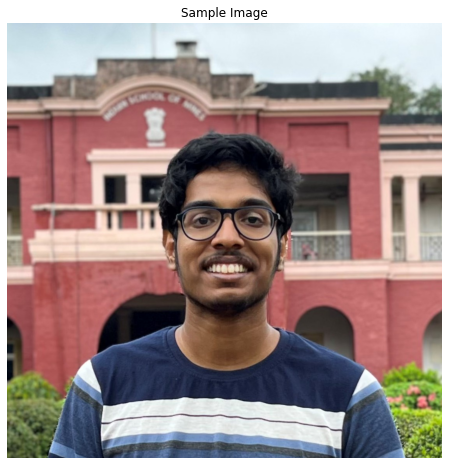

In [5]:
# Reading an image
sample = cv2.imread('/content/drive/MyDrive/Snapchat Filter/IMG_0502.jpg')
plt.figure(figsize = [8, 8])

# Displaying the sample image.
plt.title("Sample Image");plt.axis('off');plt.imshow(sample[:,:,::-1]);plt.show()#the image is converted from BGR to RGB

**Face Detection**

Detecting the faces and getting the co-ordinates of the bounding box.

In [6]:
# Perform face detection after converting the image into RGB format.
face_detection_results = face_detection.process(sample[:,:,::-1])

if face_detection_results.detections:
    
    for face_no, face in enumerate(face_detection_results.detections):
        
        print(f'FACE NUMBER: {face_no+1}')
        print('---------------------------------')
        print(f'FACE CONFIDENCE: {round(face.score[0], 2)}')
        
        face_data = face.location_data
        print(f'\nFACE BOUNDING BOX:\n{face_data.relative_bounding_box}')

FACE NUMBER: 1
---------------------------------
FACE CONFIDENCE: 0.98

FACE BOUNDING BOX:
xmin: 0.37890681624412537
ymin: 0.40229320526123047
width: 0.2529658377170563
height: 0.25296568870544434



These are normalised co-ordinates[0-1].

**Displaying the bounding box and some key landmarks on the face.**

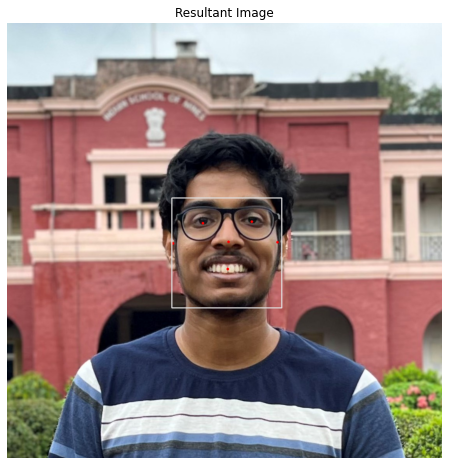

In [7]:
sample_copy = sample[:,:,::-1].copy()

if face_detection_results.detections:
  
    for face_no, face in enumerate(face_detection_results.detections):
        
        mp_drawing.draw_detection(image=sample_copy, detection=face, 
                                 keypoint_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0),
                                                                              thickness=2,
                                                                              circle_radius=2))
fig = plt.figure(figsize = [8, 8])
#displaying the resultant image
plt.title("Resultant Image");plt.axis('off');plt.imshow(sample_copy);plt.show()

*But these key lanmarks aren't very accurate in every scenario. Therefore we will use mediapipe's faial landmark detection.*

**Facial Landmark Detection**

In [8]:
mp_face_mesh = mp.solutions.face_mesh

#face landmarks function for images.
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         min_detection_confidence=0.5)

#face landmarks function for videos.
face_mesh_videos = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, 
                                         min_detection_confidence=0.5,min_tracking_confidence=0.3)

mp_drawing_styles = mp.solutions.drawing_styles

**Printing eye landmark co-ordinates**

In [9]:
face_mesh_results = face_mesh_images.process(sample[:,:,::-1])

LEFT_EYE_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LEFT_EYE)))
RIGHT_EYE_INDEXES = list(set(itertools.chain(*mp_face_mesh.FACEMESH_RIGHT_EYE)))

if face_mesh_results.multi_face_landmarks:
    
    for face_no, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):
        
        print(f'FACE NUMBER: {face_no+1}')
        print('-----------------------')
  
        print(f'LEFT EYE LANDMARKS:\n')
        
        for LEFT_EYE_INDEX in LEFT_EYE_INDEXES[:2]:
            
            print(face_landmarks.landmark[LEFT_EYE_INDEX])
        
        print(f'RIGHT EYE LANDMARKS:\n')
        
        for RIGHT_EYE_INDEX in RIGHT_EYE_INDEXES[:2]:
            
            print(face_landmarks.landmark[RIGHT_EYE_INDEX])

FACE NUMBER: 1
-----------------------
LEFT EYE LANDMARKS:

x: 0.546467661857605
y: 0.4503735899925232
z: 0.01735973358154297

x: 0.5553988218307495
y: 0.44779324531555176
z: 0.015862610191106796

RIGHT EYE LANDMARKS:

x: 0.441784530878067
y: 0.4518348276615143
z: 0.018106859177350998

x: 0.42897409200668335
y: 0.4600445032119751
z: 0.02893839403986931



**Facial Landmark detection Function**

This function detects facial landmarks and draws face mesh tesselation and contours and displays it along with the original pic side by side if asked.

In [10]:
def detectFacialLandmarks(image, face_mesh, display = True):
    
    #converting it into RGB format.
    results = face_mesh.process(image[:,:,::-1])

    output_image = image[:,:,::-1].copy()
    
    if results.multi_face_landmarks:

        for face_landmarks in results.multi_face_landmarks:
            #drawing face mesh tesselation
            mp_drawing.draw_landmarks(image=output_image, landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_TESSELATION,
                                      landmark_drawing_spec=None, 
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

            #drawing face mesh contour
            mp_drawing.draw_landmarks(image=output_image, landmark_list=face_landmarks,
                                      connections=mp_face_mesh.FACEMESH_CONTOURS,
                                      landmark_drawing_spec=None, 
                                      connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())

    if display:
        
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image);plt.title("Output");plt.axis('off');
        
    else:
        
        #output image in BGR format.
        return np.ascontiguousarray(output_image[:,:,::-1], dtype=np.uint8), results 

**Reading some sample images**

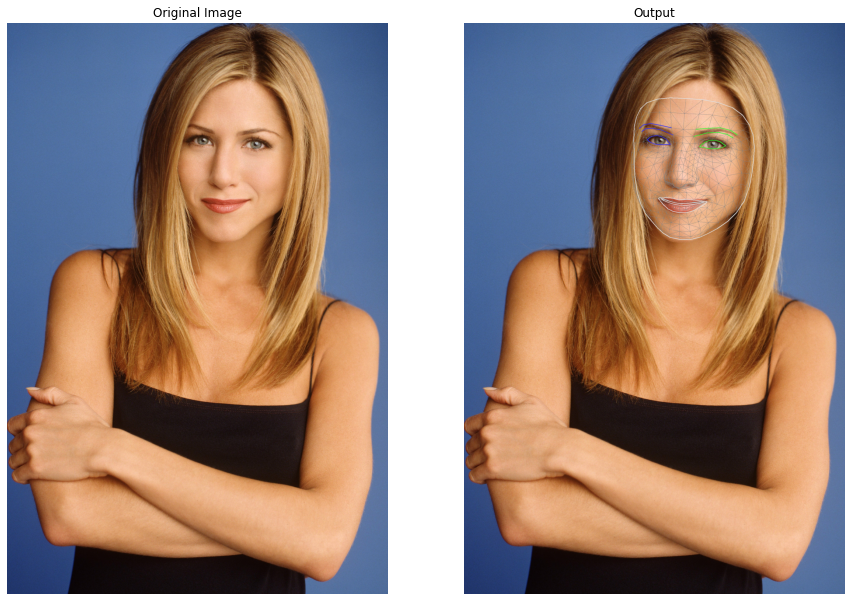

In [11]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/GettyImages-908311 (1).jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)

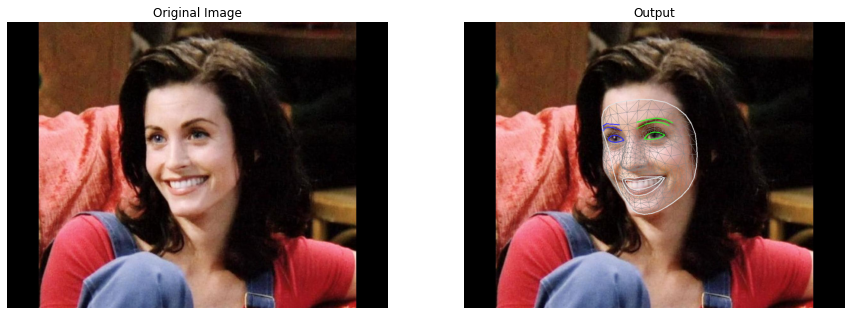

In [12]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/Monica.jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)

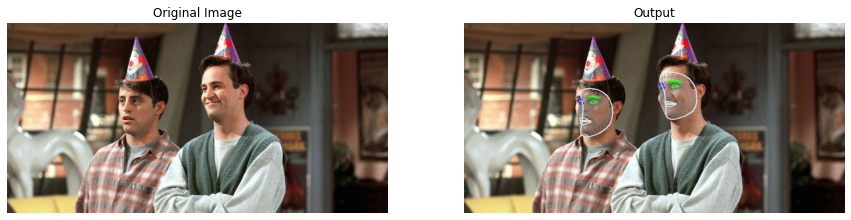

In [13]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/2ej7akjg4nx71 (1).jpg')
detectFacialLandmarks(image, face_mesh_images, display=True)

**Face Expression Recognition**

We can see if:
* The eyes (left eye and the right eye) are closed or open.
* The mouth is closed or open.

If we can calculate the size of each part (i.e, both the eyes and the mouth), based on that we can see if they are open or not. Based on the relative size of the part with respect to the face, we can say if they  are open or not.

In [14]:
def getSize(image, face_landmarks, INDEXES):
  
    image_height, image_width, _ = image.shape
    INDEXES_LIST = list(itertools.chain(*INDEXES))
    
    landmarks = []

    for INDEX in INDEXES_LIST:
        
        landmarks.append([int(face_landmarks.landmark[INDEX].x * image_width),
                               int(face_landmarks.landmark[INDEX].y * image_height)])
    
    # Calculate the width and height of the face part.
    _, _, width, height = cv2.boundingRect(np.array(landmarks))
    #landmarks of the face part
    landmarks = np.array(landmarks)
    
    return width, height, landmarks

A function to check if a particular part of the face is open or not which uses getSize().

In [15]:
def isOpen(image, face_mesh_results, face_part, threshold=5, display=True):

    
    image_height, image_width, _ = image.shape
    
    output_image = image.copy()
    
    # a dictionary to store the isOpen status of the face part of all the detected faces.
    status={}
    
    # Check if the face part is mouth.
    if face_part == 'MOUTH':
        
      
        INDEXES = mp_face_mesh.FACEMESH_LIPS
        loc = (10, image_height - image_height//40)
        increment=-30
        
    # Check if the face part is left eye.    
    elif face_part == 'LEFT EYE':
        
        INDEXES = mp_face_mesh.FACEMESH_LEFT_EYE
        loc = (10, 30)
        increment=30
    
    # Check if the face part is right eye.    
    elif face_part == 'RIGHT EYE':
        
        INDEXES = mp_face_mesh.FACEMESH_RIGHT_EYE 
        loc = (image_width-200, 30)
        increment=30
    
    else:
        return
    
    for face_no, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):
        
        _, height, _ = getSize(image, face_landmarks, INDEXES)
        _, face_height, _ = getSize(image, face_landmarks, mp_face_mesh.FACEMESH_FACE_OVAL)
        
        # Check if the face part is open.
        if (height/face_height)*100 > threshold:
            
            status[face_no] = 'OPEN'
            #write in green colur if open.
            color=(0,255,0)
        
        else:
            status[face_no] = 'CLOSE'
            #write in red colour if closed.
            color=(0,0,255)
        
        # Write the face part isOpen status on the output image.
        cv2.putText(output_image, f'FACE {face_no+1} {face_part} {status[face_no]}.', 
                    (loc[0],loc[1]+(face_no*increment)), cv2.FONT_HERSHEY_PLAIN, 0.8, color, 2)
                
    # if the output image needs to be displayed.
    if display:

        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    else:
        return output_image, status

**Now reading and displaying some results.**

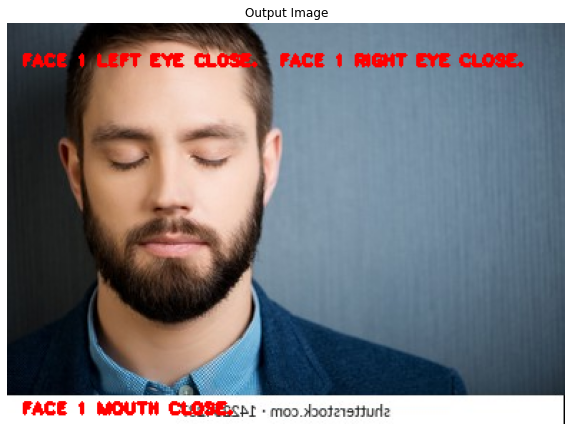

In [16]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/img.jpg')
image = cv2.flip(image, 1)
_, face_mesh_results = detectFacialLandmarks(image, face_mesh_images, display=False)
if face_mesh_results.multi_face_landmarks:
    output_image, _ = isOpen(image, face_mesh_results, 'MOUTH', threshold=15, display=False)
    output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
    isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)

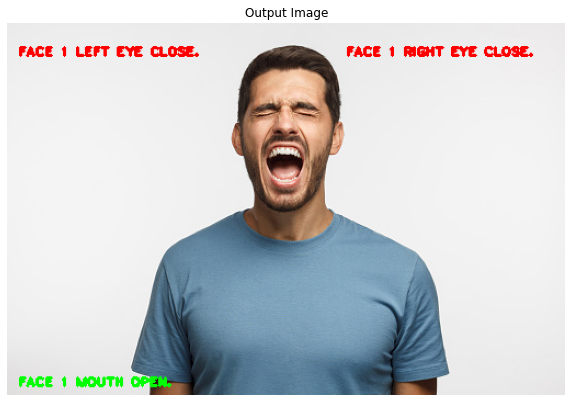

In [17]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/istockphoto-1041127064-170667a.jpg')
image = cv2.flip(image, 1)
_, face_mesh_results = detectFacialLandmarks(image, face_mesh_images, display=False)
if face_mesh_results.multi_face_landmarks:
    output_image, _ = isOpen(image, face_mesh_results, 'MOUTH', threshold=15, display=False)
    output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
    isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)

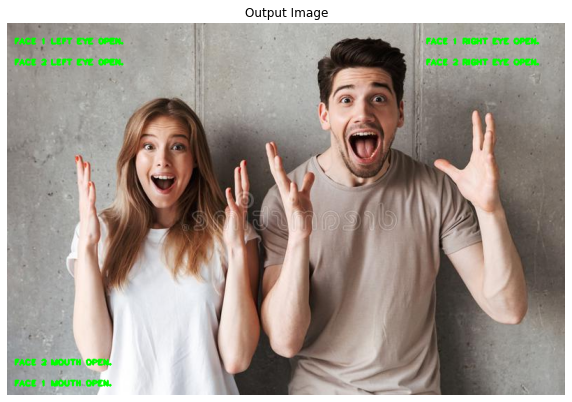

In [18]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/exc.jpg')
image = cv2.flip(image, 1)
_, face_mesh_results = detectFacialLandmarks(image, face_mesh_images, display=False)
if face_mesh_results.multi_face_landmarks:
    output_image, _ = isOpen(image, face_mesh_results, 'MOUTH', threshold=15, display=False)
    output_image, _ = isOpen(output_image, face_mesh_results, 'LEFT EYE', threshold=5, display=False)
    isOpen(output_image, face_mesh_results, 'RIGHT EYE', threshold=5)

**Snapchat Filter based on Facial Expressions**

In [19]:
def overlay(image, filter_img, face_landmarks, face_part, INDEXES, display=True):
  
    
    output_img = image.copy()
    

    try:
    
        filter_img_height, filter_img_width, _  = filter_img.shape
        _, face_part_height, landmarks = getSize(image, face_landmarks, INDEXES)
        
        required_height = int(face_part_height*5.5)
         
        resized_filter_img = cv2.resize(filter_img, (int(filter_img_width*
                                                         (required_height/filter_img_height)),
                                                     required_height))
        
        filter_img_height, filter_img_width, _  = resized_filter_img.shape

        _, filter_img_mask = cv2.threshold(cv2.cvtColor(resized_filter_img, cv2.COLOR_BGR2GRAY),
                                           25, 255, cv2.THRESH_BINARY_INV)
        #center of face part
        center = landmarks.mean(axis=0).astype("int")

        if face_part == 'MOUTH':

            #the location where the mouth filter will be placed.  
            location = (int(center[0] - filter_img_width / 3), int(center[1]))

        #if the face part is an eye.
        else:

            #the location where the eye filter image will be placed.  
            location = (int(center[0]-filter_img_width/2), int(center[1]-filter_img_height/2))

        #ROI meansRegion of interest
        ROI = image[location[1]: location[1] + filter_img_height,
                    location[0]: location[0] + filter_img_width]

        resultant_image = cv2.bitwise_and(ROI, ROI, mask=filter_img_mask)

        
        resultant_image = cv2.add(resultant_image, resized_filter_img)

        output_img[location[1]: location[1] + filter_img_height,
                        location[0]: location[0] + filter_img_width] = resultant_image
            
    except Exception as e:
        pass
    
    # if the output to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_img[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
            
        # Return the output image.
        return output_img


Using the above isOpen() and overlay() functions we canapply the filter based on expressions.

In [20]:
def custom_filter(image, right_eye, left_eye, mouth):
    image = cv2.flip(image, 1)
    _, face_mesh_results = detectFacialLandmarks(image, face_mesh_images, display=False)
    if face_mesh_results.multi_face_landmarks:
   
            _, mouth_status = isOpen(image, face_mesh_results, 'MOUTH', 
                                     threshold=15, display=False)
        
            _, left_eye_status = isOpen(image, face_mesh_results, 'LEFT EYE', 
                                        threshold=4.5 , display=False)
        
            _, right_eye_status = isOpen(image, face_mesh_results, 'RIGHT EYE', 
                                         threshold=4.5, display=False)
        
            for face_num, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):
            
                if left_eye_status[face_num] == 'OPEN':
                    image = overlay(image, left_eye, face_landmarks,
                                'LEFT EYE', mp_face_mesh.FACEMESH_LEFT_EYE, display=False)
            
                if right_eye_status[face_num] == 'OPEN':
                    image = overlay(image, right_eye, face_landmarks,
                                'RIGHT EYE', mp_face_mesh.FACEMESH_RIGHT_EYE, display=False)
          
                if mouth_status[face_num] == 'OPEN':
                    image = overlay(image, mouth, face_landmarks, 
                                'MOUTH', mp_face_mesh.FACEMESH_LIPS, display=False)
    #displaying the output image
    plt.figure(figsize=[10,10])
    plt.imshow(image[:,:,::-1]);plt.title("Output Image");plt.axis('off')

The above function was defined in such a way that:
* If the eyes are open, apply a specific image overlay which we pass for each eye.
* If the mouth is open, apply a specific image overlay which we pass.

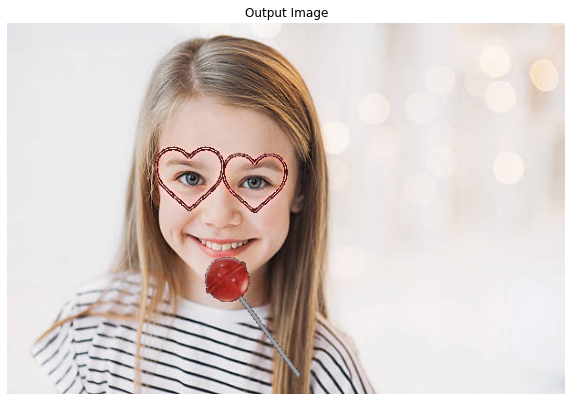

In [21]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/test1.jpg')
left_eye = cv2.imread('/content/drive/MyDrive/Snapchat Filter/flat,750x1000,075,f.u4.jpg')
right_eye = cv2.imread('/content/drive/MyDrive/Snapchat Filter/flat,750x1000,075,f.u4.jpg')
mouth = cv2.imread('/content/drive/MyDrive/Snapchat Filter/lp.jpg')
custom_filter(image, right_eye, left_eye, mouth)

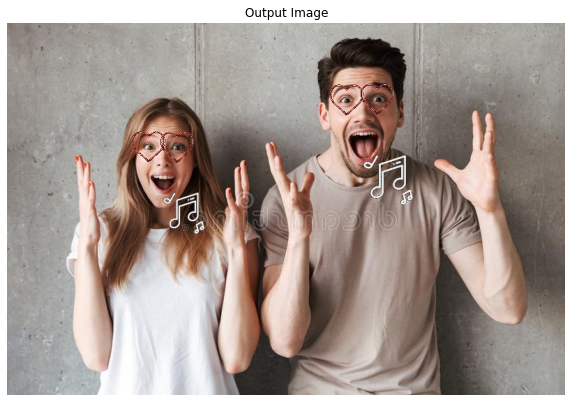

In [23]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/exc.jpg')
left_eye = cv2.imread('/content/drive/MyDrive/Snapchat Filter/flat,750x1000,075,f.u4.jpg')
right_eye = cv2.imread('/content/drive/MyDrive/Snapchat Filter/flat,750x1000,075,f.u4.jpg')
mouth = cv2.imread('/content/drive/MyDrive/Snapchat Filter/music.jpg')
custom_filter(image, right_eye, left_eye, mouth)

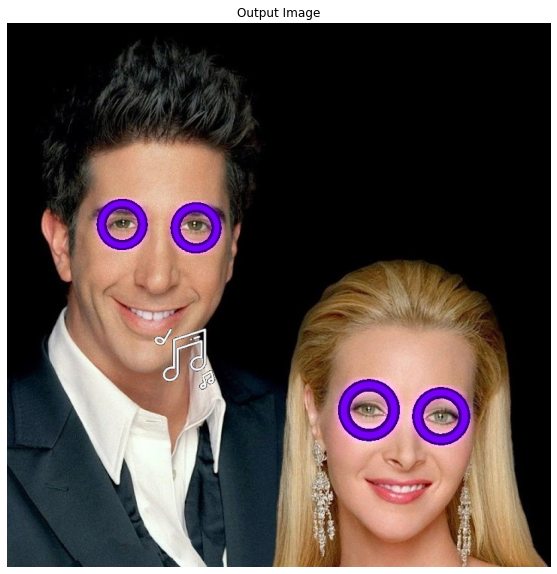

In [26]:
image = cv2.imread('/content/drive/MyDrive/Snapchat Filter/ross_phoebe.jpg')
left_eye = cv2.imread('/content/drive/MyDrive/Snapchat Filter/maxresdefault.jpg')
right_eye = cv2.imread('/content/drive/MyDrive/Snapchat Filter/maxresdefault.jpg')
mouth = cv2.imread('/content/drive/MyDrive/Snapchat Filter/music.jpg')
custom_filter(image, right_eye, left_eye, mouth)